This notebook filters the data, normalizes the features, and additionally plots the data correlation.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read in the input data first
input_file = "cardio_train.csv"
cardio_train = pd.read_csv(input_file)

In [2]:
#doing some initial checks


cardio_map = {True:1, False:0}
cardio_train['cardio']=cardio_train['cardio'].map(cardio_map)
num_obs = len(cardio_train)
num_true = len(cardio_train.loc[cardio_train['cardio'] == 1])  #finding how many people have cardio failure
num_false = len(cardio_train.loc[cardio_train['cardio'] == 0]) #finding how many people don't have cardio failure
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

num_all = len(cardio_train)
num_women = len(cardio_train.loc[cardio_train['gender'] == 1])
num_men = len(cardio_train.loc[cardio_train['gender'] == 2])
print("Number of Female cases:  {0} ({1:2.2f}%)".format(num_women, (num_women/num_all) * 100))
print("Number of Male cases: {0} ({1:2.2f}%)".format(num_men, (num_men/num_all) * 100))

Number of True cases:  34979 (49.97%)
Number of False cases: 35021 (50.03%)
Number of Female cases:  45530 (65.04%)
Number of Male cases: 24470 (34.96%)


In [3]:

def remove_outliers(dataframe, column_name,  threshold_low, threshold_hi):
    """
    Removes outliers

    """
    low_valid = dataframe[column_name] > threshold_low  
    hi_valid = dataframe[column_name] < threshold_hi
    column_valid = [a and b for a,b in zip(low_valid,hi_valid)]
    truncated_data = dataframe[column_valid]
    removeAmount = list(dataframe.shape)[0] - list(truncated_data.shape)[0]
    print('Number removed:',removeAmount)
    return truncated_data

def plot_features(x,feature_names):
    """
    This plots the features in a histogram.
    """
    for feat in feature_names:
        plt.hist(x[feat],32)
        plt.xlabel(feat)
        if(feat == "bmi"):
            plt.savefig('BMI_graph_updated' + '.png', bbox_inches='tight')
        plt.show()
        
        
def normalize(X):
    """
    Normalizes features
    """
    meanX= np.mean(X) #calculating mean
    X =X-meanX  
    stdX= np.std(X) #calculating standard deviation
    X=X/stdX
    return X


def plot_corr(df,size=11): 
    """
    Function plots a graphical correlation matrix for each pair (of features) in the dataframe

    Displays:
        matrix of correlation between columns.  Yellow means that they are highly correlated.
                                           
    """
    
    corr = df.corr()
    corr# calling the correlation function (on dataframe)
    fig, ax = plt.subplots(figsize=(size,size))
    c = ax.matshow(np.abs(corr)) # color code based on correlation
    plt.colorbar(c)
    plt.xticks(range(len(corr.columns)),corr.columns) # draw x tickmarks
    plt.yticks(range(len(corr.columns)),corr.columns) # draw y tickmarks
    plt.show()
   

In [4]:

def print_corr_info(x):
     """
     creates a bar graph to plot the correlations

     """
     feat_names = x.index
     unsorted_corr = np.abs(x)
     print("Unsorted Abs", unsorted_corr)
     sorted_order = np.argsort(unsorted_corr)[::-1]
     print('sorted order', sorted_order)
     sorted_corr = unsorted_corr[sorted_order[1:]] 
     sorted_feat_names = feat_names[sorted_order[1:]]
     for id in range(len(sorted_corr)):
            print('{0:<20} {1:.4f}'.format(sorted_feat_names[id], sorted_corr[id]))

     plt.bar(sorted_feat_names, sorted_corr, width = 0.5, color=(0.4,0.9,0.9,1))
     ax = plt.gca()
     plt.grid()
     plt.title('Correlation Analysis')
     plt.xlabel('Feature')
     plt.ylabel('Correlation')
     plt.setp(ax.get_xticklabels(), fontsize = 10, rotation = 45)
     plt.show() 


In [5]:
#adding BMI to the dataframe (using the formula that BMI is weight/height^2)
height = list(cardio_train['height'])
weight = list(cardio_train['weight'])
bmi = []

for i in range(len(height)):
    height[i] = height[i]/100
    bmi.append(weight[i]/((height[i])**2))
cardio_train.insert(0,'bmi',bmi)
cardio_train.drop("weight", inplace=True, axis=1)
cardio_train.drop("height", inplace=True, axis=1)
cardio_train.drop("id", inplace=True, axis=1)

feature_cols = list(cardio_train.columns[:-1])


bmi_truncated_data = remove_outliers(cardio_train,'bmi',10,50)

ap_hi_truncated_data = remove_outliers(bmi_truncated_data, "ap_hi", 0, 250)
final_data = remove_outliers(ap_hi_truncated_data, "ap_lo", 0, 250)
final_data.to_csv("cardio_train_not_normalized.csv",index=False )


Number removed: 250
Number removed: 47
Number removed: 960


In [6]:
valid = final_data['ap_hi'] > final_data['ap_lo']
truncated_valid_bp_data = final_data[valid]
print('Removed {numsamp:d} samples'.format(numsamp=list(final_data.shape)[0] - list(truncated_valid_bp_data.shape)[0]))


Removed 275 samples


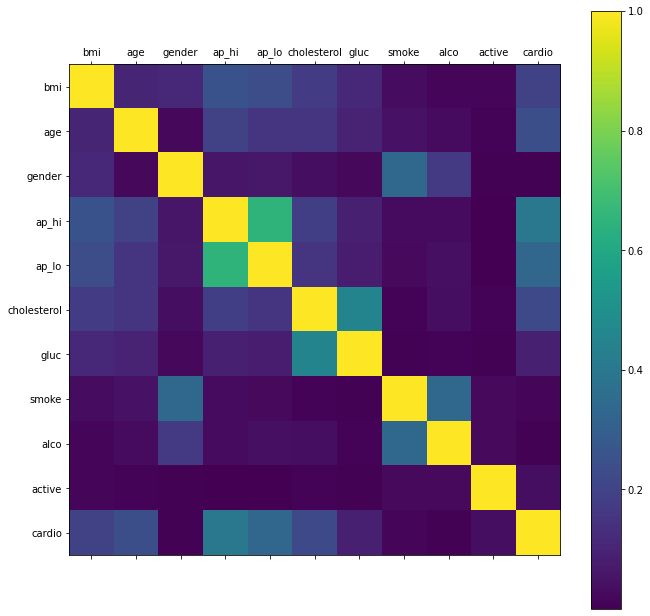

Unsorted Abs bmi            0.192732
age            0.239940
gender         0.008040
ap_hi          0.401841
ap_lo          0.330643
cholesterol    0.221609
gluc           0.089024
smoke          0.016300
alco           0.007803
active         0.037413
cardio         1.000000
Name: cardio, dtype: float64
sorted order cardio         10
active          3
alco            4
smoke           1
gluc            5
cholesterol     0
ap_lo           6
ap_hi           9
gender          7
age             2
bmi             8
Name: cardio, dtype: int64
ap_hi                0.4018
ap_lo                0.3306
age                  0.2399
cholesterol          0.2216
bmi                  0.1927
gluc                 0.0890
active               0.0374
smoke                0.0163
gender               0.0080
alco                 0.0078


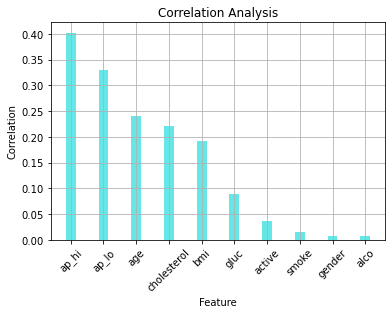

In [7]:
#plotting correlation
plot_corr(final_data)
corr = final_data.corr()
x = corr['cardio']
print_corr_info(x)

#plt.savefig('Correlation Graph' + '.png', bbox_inches='tight')

plt.show()

In [8]:
print(feature_cols)
print(final_data.head())

for feature in feature_cols:
    final_data[feature] = normalize(final_data[feature]) #calling normalizing function 
    
#giving nice names
final_data.rename(columns={'ap_hi':'systolic', 'ap_lo':'diastolic', 'gluc': 'glucose', 'alco': 'alcoholic', 'smoke': 'smoking'}, inplace = True)
final_data.to_csv("cardio_train_filtered.csv",index=False )



['bmi', 'age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
         bmi    age  gender  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0  21.967120  18393       2    110     80            1     1      0     0   
1  34.927679  20228       1    140     90            3     1      0     0   
2  23.507805  18857       1    130     70            3     1      0     0   
3  28.710479  17623       2    150    100            1     1      0     0   
4  23.011177  17474       1    100     60            1     1      0     0   

   active  cardio  
0       1       0  
1       1       1  
2       0       1  
3       1       1  
4       0       0  


<ipython-input-8-a64dc015fbd6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[feature] = normalize(final_data[feature]) #calling normalizing function
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
